### ReAct Agent
1. User: please help modify image of workload "payment" to nginx:v1.0.
2. Assistant: call tools: get_deployment.
3. Assistant: call tools: patch_deployment if step#2 is successful.
4. Assistant: modify successfully.

In [1]:
%pip install -qU langgraph langchain-openai

Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
from langchain_openai import ChatOpenAI
from typing import Literal
from langchain_core.tools import tool
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState
from getpass import getpass

key=getpass()

# ++ lang smith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = key
os.environ["LANGCHAIN_PROJECT"] = "default"

In [9]:
# tools
@tool
def get_deployment(deployment_name: str):
    """Use this to get deployment YAML."""
    print("get deployment: ", deployment_name)
    # TODO: K8s API to create
    return """
apiVersion: apps/v1
kind: Deployment
metadata:
  name: payment
spec:
    selector:
        matchLabels:
            app: payment
    template:
        metadata:
        labels:
            app: payment
        spec:
        containers:
        - name: payment
            image: nginx
            ports:
            - containerPort: 80
"""

@tool
def apply_deployment(patch_json: str):
    """Edit the deployment YAML."""
    print("apply deployment: ", patch_json)
    # TODO: K8s API to patch
    return "deployment applied"

# build tool node by tools
tools = [get_deployment, apply_deployment]
tool_node = ToolNode(tools)

In [8]:
key=getpass()

llm = ChatOpenAI(
    model="gpt-4o-mini",
    api_key=key,
    base_url="https://api.apiyi.com/v1"
).bind_tools(tools)

def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}

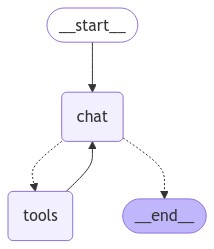

In [10]:
# helper to determine whether continue to reason
# determined by the last msg from llm
def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"

# graph, node, edge
workflow = StateGraph(MessagesState)
workflow.add_node("chat", call_model)
workflow.add_node("tools", tool_node)
workflow.add_edge("__start__", "chat")
# ++cond, if true then tools, else "__end__" 
workflow.add_conditional_edges(
    "chat",
    should_continue,
)
# loop from tools to chat
workflow.add_edge("tools", "chat")
app = workflow.compile()

# draw
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [11]:
for chunk in app.stream(
    {"messages": [("human", "please help modify image of workload \"payment\" to nginx:v1.0.")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

please help modify image of workload "payment" to nginx:v1.0.
================================== Ai Message ==================================
Tool Calls:
  get_deployment (call_oF6k5hLXfLnADghg7cX5oE1h)
 Call ID: call_oF6k5hLXfLnADghg7cX5oE1h
  Args:
    deployment_name: payment
get deployment:  payment
================================= Tool Message =================================
Name: get_deployment


apiVersion: apps/v1
kind: Deployment
metadata:
  name: payment
spec:
    selector:
        matchLabels:
            app: payment
    template:
        metadata:
        labels:
            app: payment
        spec:
        containers:
        - name: payment
            image: nginx
            ports:
            - containerPort: 80

================================== Ai Message ==================================
Tool Calls:
  apply_deployment (call_KEUmHh5mgWFj8pVEjM0KIZaW)
 Call ID: call_KEUmHh5mgWFj